Машинное обучение в
задачах распознавания
текста

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ai-vs-human-text:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4288635%2F7379779%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240516%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240516T091953Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8907be94dfc03b159932e451185230c23f9bb530dd7b899b8e7cccbaea7f4c84c6205749c8703003b67271ba91f366b186921d3c7899556922c9dd5f6bd933137ddc3445524a5ffa6fcc0d2b6f38df8069cd35cfe22a6c808762933106cd33110c33038691a2229246a23327d13ac8a25d6e18a5d935467194ef3e7e9b101d3c5ef24e8c41fc8738bcc53fac086db6e1d96bf8ebcc8ab1c6214e61ecb02d54315fac5ecc366ae415b57d965c6562a656883994f4127c5ab60abbf169a156373359b1ae2e57bac6bc8e80b9cce67fc99e5d39aa93962fc1b152156180b3ad43f31595a8baa0e77606ba8dec174ad21869a15f57fbf7fb964447bda9d8e07bd221'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 366594744 bytes downloaded
Downloaded and uncompressed: ai-vs-human-text
Data source import complete.


подгружаем необходимые библиотеки и импортируем данные

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

In [3]:
df = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')

In [ ]:
df.shape

(487235, 2)

In [ ]:
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [ ]:
df.tail()

,text,generated
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0
487234,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0.0


Выведем основную инофрмацию о датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


In [ ]:
df.isnull()

,text,generated
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
487230,False,False
487231,False,False
487232,False,False
487233,False,False


In [ ]:
df.describe()

,generated
count,487235.000000
mean,0.372383
std,0.483440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df.duplicated().sum()

0

Мой датасет содержит 487235 стрток и 2 столбца. В первом столбце находится текст, а во втором классификатор, где 0 - это текст написанный человеком, а 1 - нейросетью. кроме того отсутствуют дубликаты строк

Построим график распределения целевой переменной классификации

<Axes: xlabel='generated', ylabel='count'>

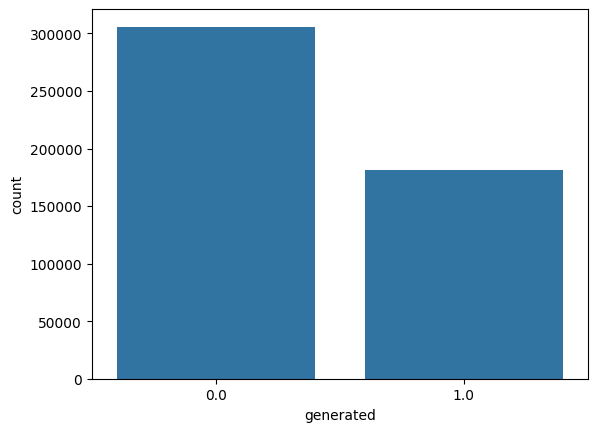

In [ ]:
sns.countplot(data=df,x='generated')

По графику видно, что в датасете превалируют наблюдения, не сгенерированные нейросетью

Покажем это в цифрах

In [ ]:
print('Total Texts:', df['generated'].count())
print('Human Written Texts:', (df['generated'] == 0.0).sum())
print('AI Generated Texts:', (df['generated'] == 1.0).sum())


Total Texts: 487235
Human Written Texts: 305797
AI Generated Texts: 181438


А так же в процентном соотношении

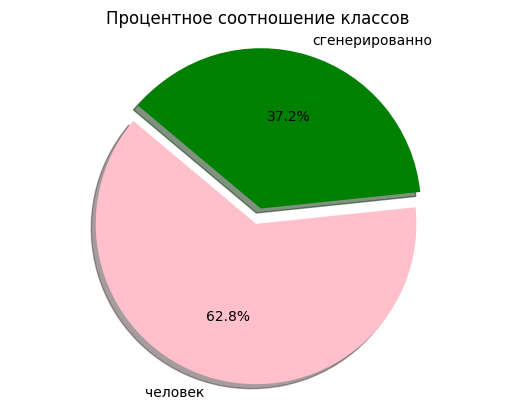

In [ ]:
import matplotlib.pyplot as plt

human = ((df['generated'] == 0.0).sum() / df['generated'].count()) * 100
ai = ((df['generated'] == 1.0).sum() / df['generated'].count()) * 100
labels = 'человек', 'сгенерированно'
sizes = [human, ai]
colors = ['pink', 'green']
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Процентное соотношение классов')
plt.show()

# Предварительная обработка данных

In [ ]:
df['text'][0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

в тексте много не нужных знаков препенания и символов.

Удаление знаков препинания из датасета при обучении модели текстового анализа может быть полезным по нескольким причинам:

1. Улучшение обработки текста: Знаки препинания не всегда содержат полезную информацию для модели, и их наличие может затруднить обработку текста. Удаление знаков препинания помогает сделать текст более чистым и легким для анализа.

2. Предотвращение искажений: Наличие знаков препинания может исказить результаты анализа, особенно при использовании методов обработки естественного языка. Например, пунктуация может влиять на распознавание слов и фраз, что может привести к неправильным выводам модели.

3. Уменьшение шума: Знаки препинания могут быть рассмотрены моделью как шум или ненужная информация, которая может повлиять на качество модели. Удаление знаков препинания позволяет сосредоточиться на существенных особенностях текста.

Таким образом, удаление знаков препинания из датасета при обучении модели помогает улучшить обработку текста, предотвратить искажения результатов и снизить уровень шума в данных, что в конечном итоге способствует повышению качества и эффективности модели текстового анализа.

Удалим каретки и слэши из текста

In [4]:
def remove_tags(text):
    tags = ['\n', '\'']
    for tag in tags:
        text = text.replace(tag, '')

    return text


df['text'] = df['text'].apply(remove_tags)


In [ ]:
df['text'][0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "P

In [5]:
import string

In [6]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Теперь удалим пунктацию из текста

In [7]:
def remove_punc(text):
    new_text = [x for x in text if x not in string.punctuation]
    new_text = ''.join(new_text)
    return new_text

df['text']=df['text'].apply(remove_punc)


Проверим как выполнился код, просмотрев первый и последний тексты датасета

In [ ]:
df['text'][0]

'Cars Cars have been around since they became famous in the 1900s when Henry Ford created and built the first ModelT Cars have played a major role in our every day lives since then But now people are starting to question if limiting car usage would be a good thing To me limiting the use of cars might be a good thing to doIn like matter of this article In German Suburb Life Goes On Without Cars by Elizabeth Rosenthal states how automobiles are the linchpin of suburbs where middle class families from either Shanghai or Chicago tend to make their homes Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europeand up to 50 percent in some carintensive areas in the United States Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go Article Paris bans driving due to 

In [ ]:
df['text'][487234]

'Richard Non Jimmy Carter and Bob Dole and other companies have all agreed to abolish the Electoral College and I to agree Xor many reasons One ox the major issue is that the voters dont know what really happens to their vote Another issue to add is that the electoral collage is unfair outdated and irrationalDo the citizens that go and vote Xor their candidate actually choose Xor the candidates electors In the text is states that not only do I vote Xor candidates electors but also  help choose the states electors when you vote Xor the president This meaning that my vote counts Xor several things but was I aware Maybe not because I simply think Im voting Xor a candidate running Xor president not the candidates elector The Electoral College was meet Xor a compromise between Congress and Citizens not all these extra peopleThis year voters can expect another close election in which the popular vote winner could lose again Certainly this doesnt make since because how could the winner ox the

# **Проверка орфографии**


Эта проверка позволит нам сохранить корректность данных, так как орфографические ошибки в тексте могут привести к искажению смысла выраженного сообщения. Проверка орфографии позволяет обнаружить и исправить опечатки, ошибки в написании слов и другие ошибки, что поможет модели работать с правильными данными.

Ну а так же правильная орфография поможет модели точнее определять ключевые слова, фразы и контекст в тексте, что в конечном итоге повысит качество и интерпретируемость результатов анализа.

In [8]:
import nltk
from nltk.corpus import words

nltk.download('words')
english_words = set(words.words())


def is_spelled_correctly(word):
    return word in english_words

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [9]:
word_to_check = df['text'][487232]
if is_spelled_correctly(word_to_check):
    print(f"The word '{word_to_check}' is spelled correctly.")
else:
    print(f"The word '{word_to_check}' is spelled incorrectly.")

The word 'I firmly believe that governments worldwide should take immediate action to address the pressing issue of climate change as the consequences of inaction with be catastrophic for the planet and future generations There are several competing reasons that support my positionFirstly climate change poses a significant threat to our natural environment The earths temperature is rising at an alarming rate resulting in meeting ice caps rising sea Levels and an increase in extreme weather events such as hurricanes droughts and heatwaves These environmental changes have a devastating impact on ecosystems resulting in the Loss of biodiversity habitat destruction and species extinction For example the Great Barrier Reef one of the most biodiverse ecosystems on the planet has seen a significant decline in recent years due to coral bleaching caused by warming ocean temperaturesSecondly the negative impacts of climate change extend beyond environmental concerns affecting human health and ec

In [ ]:
df['text'][487232]

'I firmly believe that governments worldwide should take immediate action to address the pressing issue of climate change as the consequences of inaction with be catastrophic for the planet and future generations There are several competing reasons that support my positionFirstly climate change poses a significant threat to our natural environment The earths temperature is rising at an alarming rate resulting in meeting ice caps rising sea Levels and an increase in extreme weather events such as hurricanes droughts and heatwaves These environmental changes have a devastating impact on ecosystems resulting in the Loss of biodiversity habitat destruction and species extinction For example the Great Barrier Reef one of the most biodiverse ecosystems on the planet has seen a significant decline in recent years due to coral bleaching caused by warming ocean temperaturesSecondly the negative impacts of climate change extend beyond environmental concerns affecting human health and economic gr

Удалим стоп-слова из текста, не несущие смысловую нагрузку для модели

Удаление стоп-слов из датасета при обучении модели текстового анализа может быть полезным по нескольким причинам:

1. Улучшение качества модели: Использование стоп-слов (часто встречающихся слов, таких как предлоги, союзы, местоимения) в обучающем датасете может замедлить процесс обучения и ухудшить точность модели из-за избыточной информации.

2. Сокращение размера датасета: Удаление стоп-слов позволяет сократить размер датасета и ускорить обучение модели за счет уменьшения количества слов, которые модель должна обработать.

3. Улучшение интерпретации результатов: После удаления стоп-слов, модель будет более фокусирована на ключевых словах и фразах, что может улучшить интерпретацию результатов и выделить более значимые особенности текста.

Таким образом, удаление стоп-слов из датасета при обучении модели помогает повысить эффективность и точность модели, сделать ее более компактной и улучшить интерпретацию результатов.

In [10]:
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_words= ' '.join(filtered_words)
    return filtered_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['text']=df['text'].apply(remove_stopwords)

# Разделим датасет на тестовую и обучающие выборки

Разделение данных на обучающую и тестовую выборки является важным шагом в аналитике данных. Это позволяет нам оценить производительность модели на независимой выборке и предотвратить переобучение.

определим переменные:

In [11]:
y=df['generated']
X=df['text']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [13]:
print(len(X_train))
print(len(y_train))

341064
341064


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(norm=None, max_df=0.8, max_features=500, decode_error='replace') # Взвешиваем вектора
X_train_vector = v.fit_transform(X_train)
X_test_vector = v.transform(X_test)

# Логистическая регрессия

Логистическая регрессия выводит прогнозы о точках в бинарном масштабе — нулевом или единичном. Если значение чего-либо равно либо больше 0.5, то объект классифицируется в большую сторону (к единице). Если значение меньше 0.5 — в меньшую (к нулю).

У каждого признака есть своя метка, равная только 0 или только 1. Логистическая регрессия является линейным классификатором и поэтому используется, когда в данных прослеживается какая-то линейная зависимость.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression( random_state=64, solver='lbfgs', max_iter=10000, n_jobs=-1)

In [ ]:
import datetime

# начальное время
start = datetime.datetime.now()
print('Время старта: ' + str(start))

clf.fit(X_train_vector, y_train)

#фиксируем и выводим время окончания работы кода
finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# вычитаем время старта из времени окончания
time_LogReg = finish - start
print(f'Время работы:  {time_LogReg}')

Время старта: 2024-05-13 14:07:27.543183
Время окончания: 2024-05-13 14:07:53.182065
Время работы:  0:00:25.638882


In [ ]:
y_pred = clf.predict(X_test_vector)

In [ ]:
y_test

419952    0.0
478535    0.0
133753    0.0
68011     0.0
195939    0.0
         ... 
467451    1.0
311626    1.0
181725    0.0
63755     0.0
320910    1.0
Name: generated, Length: 146171, dtype: float64

**Вывод результатов**

При использовании моделей классификации в машинном обучении есть три общих показателя, которые мы используем для оценки качества модели:

1. Точность (precision) : процент правильных положительных прогнозов по отношению к общему количеству положительных прогнозов.

2. Отзыв (recall) : процент правильных положительных прогнозов по отношению к общему количеству фактических положительных результатов.

3. Оценка F1 : средневзвешенное гармоническое значение точности и полноты. Чем ближе к 1, тем лучше модель.

В пакете metrics собрано множество функций, которые позволяют исследовать поведение уже обученных моделей, в том числе - метрики эффективности. Импортируем несколько нужных нам инструментов:

отчет о классификации. Он показывает всю основную информацию по итогам классификации.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

0.9798934125100054
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     91597
         1.0       0.98      0.97      0.97     54574

    accuracy                           0.98    146171
   macro avg       0.98      0.98      0.98    146171
weighted avg       0.98      0.98      0.98    146171



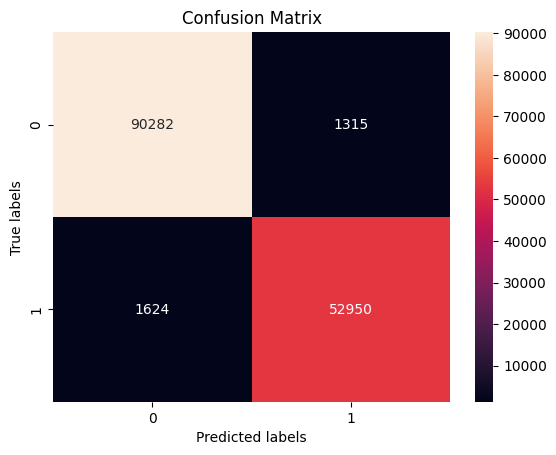

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()

cmm = confusion_matrix(y_test,y_pred)
sns.heatmap(cmm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

# Найвный Байессовский классификатор

Такой классификатор вычисляет вероятность принадлежности объекта к какому-то классу. Эта вероятность вычисляется из шанса, что какое-то событие произойдёт, с опорой на уже на произошедшие события.

Каждый параметр классифицируемого объекта считается независимым от других параметров.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()

import datetime

start = datetime.datetime.now()
print('Время старта: ' + str(start))

naive_bayes.fit(X_train_vector, y_train)

finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

time_NB = finish - start
print(f'Время работы:  {time_NB}')

Время старта: 2024-05-16 09:35:18.997684
Время окончания: 2024-05-16 09:35:19.293246
Время работы:  0:00:00.295562


Выведем кривую обучения. На графике мы видим, что как такого переобучения и недообучения нет

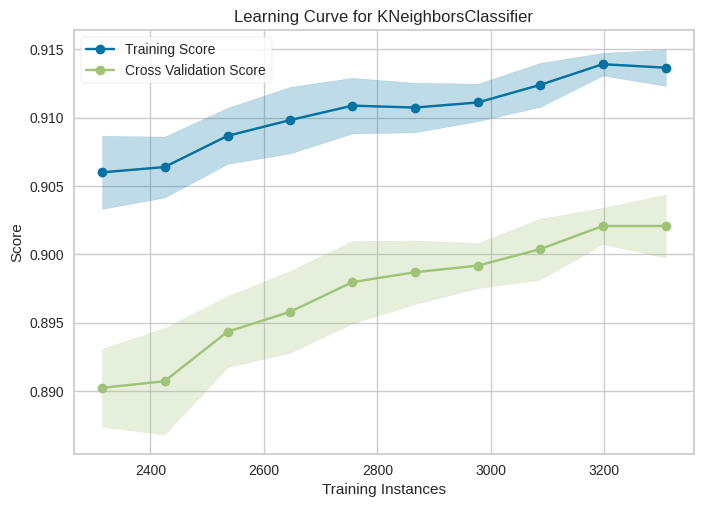

In [ ]:
visualizer = LearningCurve(
   KNeighborsClassifier(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train_vector, y_train).show()

In [ ]:
y_pred = naive_bayes.predict(X_test_vector)
accuracy_nb = accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92     91597
         1.0       0.90      0.83      0.87     54574

    accuracy                           0.90    146171
   macro avg       0.90      0.89      0.89    146171
weighted avg       0.90      0.90      0.90    146171



# Метод k-ближайших соседей

Этот метод работает с помощью поиска кратчайшей дистанции между тестируемым объектом и ближайшими к нему классифицированным объектами из обучающего набора. Классифицируемый объект будет относится к тому классу, к которому принадлежит ближайший объект набора.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = KNeighborsClassifier()

import datetime

start = datetime.datetime.now()
print('Время старта: ' + str(start))

k_neighbors.fit(X_train_vector, y_train)

finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

time_kn = finish - start
print(f'Время работы:  {time_kn}')

Время старта: 2024-05-17 19:38:16.872367
Время окончания: 2024-05-17 19:38:17.067559
Время работы:  0:00:00.195192


In [ ]:
y_pred = k_neighbors.predict(X_test_vector)
accuracy_kn = accuracy_score(y_test, y_pred)
accuracy_kn

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96       914
           1       1.00      0.30      0.46       121

    accuracy                           0.92      1035
   macro avg       0.96      0.65      0.71      1035
weighted avg       0.92      0.92      0.90      1035



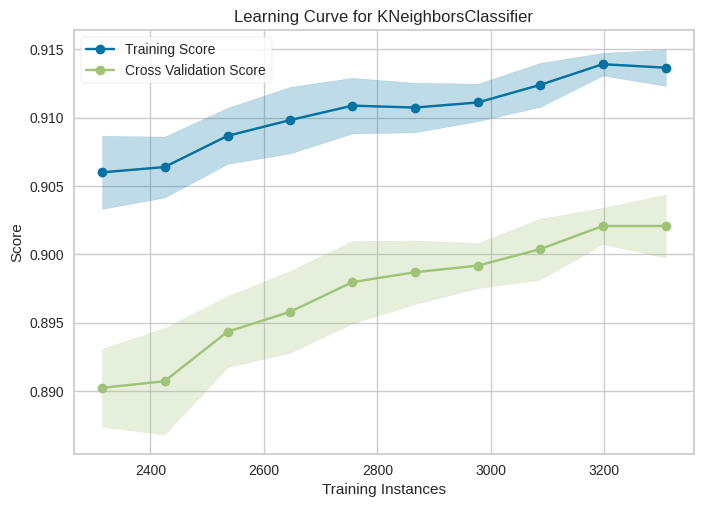

In [ ]:
visualizer = LearningCurve(
   KNeighborsClassifier(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train, y_train).show()

# Метод опорных векторов

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC()

import datetime

start = datetime.datetime.now()

svc.fit(X_train_vector, y_train)

finish = datetime.datetime.now()

time_svc = finish - start
print(time_svc)

0.9777777777777777

In [ ]:
y_pred = svc.predict(X_test_vector)
accuracy_svc = accuracy_score(y_test, y_pred)
accuracy_svc

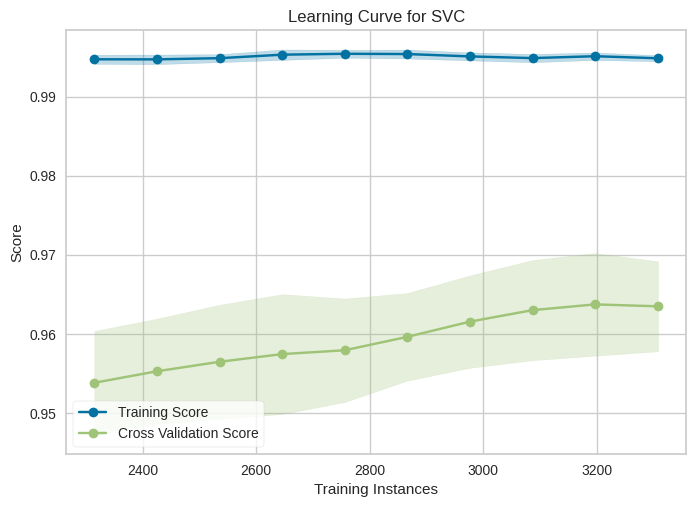

In [ ]:
visualizer = LearningCurve(
    SVC(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train_vector, y_train).show()

#Дерево решений

Этот классификатор разбивает данные на всё меньшие и меньшие подмножества на основе разных критериев, т. е. у каждого подмножества своя сортирующая категория. С каждым разделением количество объектов определённого критерия уменьшается.

Классификация подойдёт к концу, когда сеть дойдёт до подмножества только с одним объектом.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

import datetime

start = datetime.datetime.now()

decision_tree.fit(X_train_vector, y_train)

finish = datetime.datetime.now()

time_dt = finish - start

Время старта: 2024-05-17 19:22:12.936881


Выведем метрики модели

In [ ]:
y_pred = decision_tree.predict(X_test_vector)
accuracy_tree = accuracy_score(y_test, y_pred)
accuracy_tree

0.9671497584541063

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       914
           1       0.91      0.79      0.85       121

    accuracy                           0.97      1035
   macro avg       0.94      0.89      0.92      1035
weighted avg       0.97      0.97      0.97      1035



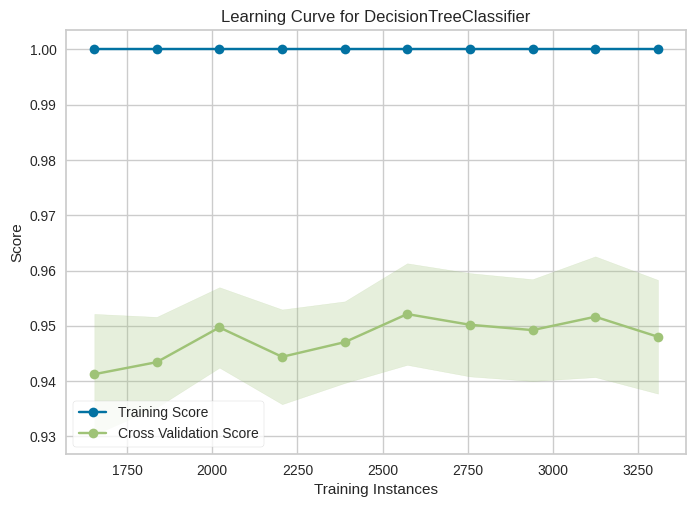

In [ ]:
visualizer = LearningCurve(
    DecisionTreeClassifier(), scoring='accuracy', train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X_train_vector, y_train).show()

#Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42)

import datetime

start = datetime.datetime.now()

random_forest.fit(X_train_vector, y_train)

finish = datetime.datetime.now()

time_rf = finish - start

0.9729468599033816

In [ ]:
y_pred = random_forest.predict(X_test_vector)

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred)
accuracy_rf

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       914
           1       0.99      0.78      0.87       121

    accuracy                           0.97      1035
   macro avg       0.98      0.89      0.93      1035
weighted avg       0.97      0.97      0.97      1035



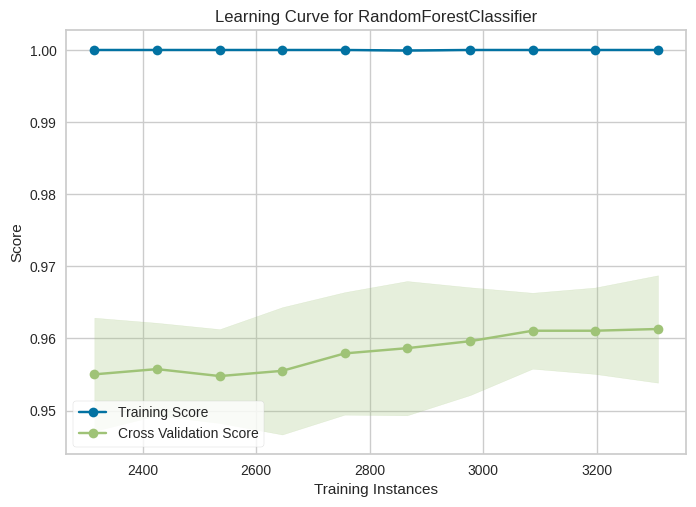

In [ ]:
visualizer = LearningCurve(
    RandomForestClassifier(), scoring='accuracy', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X_train, y_train).show()

# **Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

Pipeli neпозволяет последовательно применять список преобразователей для предварительной обработки данных и, при желании, завершать последовательность финальным предиктором для прогнозного моделирования.

Пайплайн собирает все инструменты в один конвейер без повторяющегося кода. Достаточно обучить этот конвейер на обучающей выборке и использовать его для всех нужных преобразований одной командой. Он принимает на вход признаки, преобразует их и выдаёт результат.

In [ ]:
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('naive_bayes', MultinomialNB())])

In [ ]:
# начальное время
start = datetime.datetime.now()
print('Время старта: ' + str(start))

pipeline.fit(X_train, y_train)

#фиксируем и выводим время окончания работы кода
finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# вычитаем время старта из времени окончания
print('Время работы: ' + str(finish - start))


Время старта: 2024-05-12 20:40:14.889749
Время окончания: 2024-05-12 20:42:23.093836
Время работы: 0:02:08.204087


In [ ]:
y_pred= pipeline.predict(X_test)

In [ ]:
y_pred

array([0., 0., 0., ..., 0., 0., 1.])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     91597
         1.0       0.99      0.87      0.93     54574

    accuracy                           0.95    146171
   macro avg       0.96      0.93      0.94    146171
weighted avg       0.95      0.95      0.95    146171



In [ ]:
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

для лучшей наглядности сравним показания метрик по обучающей и тестовой выборке


In [ ]:
metrics = pd.DataFrame({
    "Train": [
        accuracy_score(y_train, y_train_pred),
        precision_score(y_train, y_train_pred),
        recall_score(y_train, y_train_pred),
        f1_score(y_train, y_train_pred),
    ],
    "Test": [
        accuracy_score(y_test, y_test_pred),
        precision_score(y_test, y_test_pred),
        recall_score(y_test, y_test_pred),
        f1_score(y_test, y_test_pred),
    ],
}, index = ["Accuracy", "Precision", "Recall", "F1"])

metrics

,Train,Test
Accuracy,0.952138,0.948129
Precision,0.988423,0.988137
Recall,0.881653,0.871532
F1,0.931990,0.926179


# **Вывод результатов**

Поскольку мы имеем дело с несбалансированными классами, в нашем случае важно больше сравнивать метрики Precision и Recall, при этом учитывая Accuracy

Выбирая наилучшую модель, мы сравниваем две модели с более хорошими метриками - pipline, логистической регрессии, дерево решений, метод k-ближайших соседей. у Логистической регрессии лучше метрика Recall, что показывает, что модель более полно обнаруживает сгенерированный текст. Это важно для минимизации пропуска сгенерированного текста и обеспечения высокой степени его обнаружения. У остальных моделей высокая метрика Precision, что показывает, что модель более точно определяет сгенерированный текст. Это важно для предотвращения ложных срабатываний и ошибочного определения "человеческого" текста от сгенерированного. Для нашей задачи более значимо избежать ложных выводов, исходя из этого наилучшая модель, у которой более высокая accuracy и precision и неплохие другие метрики, - pipline.

В данной задаче распознования текста была проведена успешная работа, направленная на разделение сообщений на два класса: сгенерированных ии и нет. Результаты этой задачи имеют важное значение для различных антиплагиат програм распознающих такой текст. В ходе исследования были использованы следующие алгоритмы машинного обучения: Naive Bayes, Logistic Regresion, KNeighboors, Support Vector Machine, DecisionTreeClassifier, RandomForest, Pipline.

Для каждого алгоритма было оценено качество модели с помощью метрик accuracy, precision, recall, F1-score. Было выявлено, что алгоритм Pipline показывает наилучшее качество, а K-Nearest Neighbors - наихудшее качество для данной задачи распознования текста. Таким образом, результаты исследования показали, что машинное обучение может быть эффективно использовано для таких типов задач, в частности, для распознования сгенерированного текста. При этом выбор алгоритма машинного обучения имеет большое значение для достижения высокого качества предсказания.